In [ ]:
import os
import joblib
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [ ]:
training_data_filename = './training_data_PACE.npy'

In [ ]:
def augment_patch(patch, shape=(5, 5, 172)):
    """Generate augmented versions of a (h, w, c) patch"""
    patch = patch.reshape(shape)
    aug_patches = []

    # Original
    aug_patches.append(patch)
    
    # Horizontal flip
    aug_patches.append(np.flip(patch, axis=1))
    
    # Vertical flip
    aug_patches.append(np.flip(patch, axis=0))
    
    # Rotations
    aug_patches.append(np.rot90(patch, k=1, axes=(0, 1)))
    aug_patches.append(np.rot90(patch, k=2, axes=(0, 1)))
    aug_patches.append(np.rot90(patch, k=3, axes=(0, 1)))

    return [p.flatten() for p in aug_patches]


Loaded scaler and model.


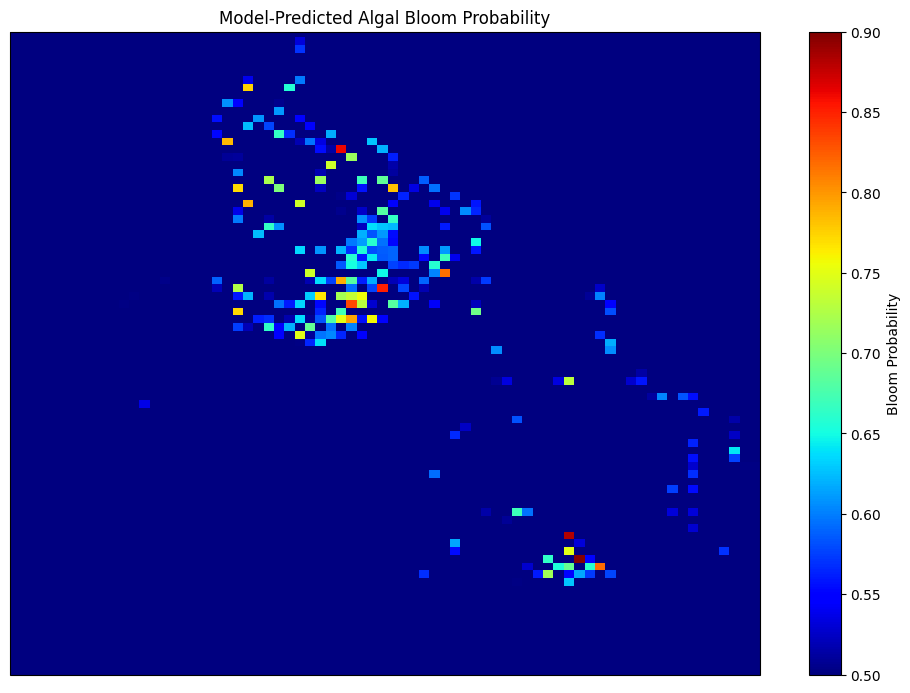

In [2]:
#!/usr/bin/env python3
import os
import math
import numpy as np
import xarray as xr
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from helpers import regrid_granule, extract_pace_patch, process_pace_granule

# ─── User parameters ───────────────────────────────────────────────────────────
MODEL_DIR     = "models"
SCALER_FILE   = os.path.join(MODEL_DIR, "scaler.pkl")
MODEL_FILE    = os.path.join(MODEL_DIR, "logistic_regression.pkl")

GRANULE_FILE  = "./data/PACE_OCI.20240603T180158.L2.OC_AOP.V3_0.nc"

BBOX          = (-83.5, 41.3, -82.45, 42.2)  # (lon_min, lat_min, lon_max, lat_max)
RES_KM        = 1.2                          # target km resolution for regridding
PATCH_SIZE    = 5
COVERAGE_MIN  = 0.40                         # minimum fraction of non-NaN in patch

params = {
            "short_names": ["PACE_OCI_L2_AOP", "PACE_OCI_L2_AOP_NRT"],
            "start_date": datetime(2024,2,1),
            "res_km": 1.2,
            "pixel_count": 5,
        }
params["sensor"] = "PACE"
params["bbox"] = (-83.5, 41.3, -82.45, 42.2)
wave_all = xr.open_dataset(GRANULE_FILE, group="sensor_band_parameters")["wavelength_3d"].data



# ─── Load scaler & model ──────────────────────────────────────────────────────
scaler = joblib.load(SCALER_FILE)
model  = joblib.load(MODEL_FILE)
print("Loaded scaler and model.")

wls, arr_stack, lat_centers, lon_centers = process_pace_granule(GRANULE_FILE, BBOX, params, wave_all)
ny, nx = len(lat_centers), len(lon_centers)                     

# ─── Extract patches & build feature matrix ───────────────────────────────────
features = []
coords   = []

for i, lat0 in enumerate(lat_centers):
    for j, lon0 in enumerate(lon_centers):
        patch_dict = extract_pace_patch(
            arr_stack=arr_stack,
            wavelengths=wave_all,
            lon0=lon0,
            lat0=lat0,
            pixel_count=PATCH_SIZE,
            lat_centers=lat_centers,
            lon_centers=lon_centers
        )
        
        # convert the dict into a 3D array, bands-first
        # ensure you use the exact same wavelengths list/order
        
        patch_arr = np.stack([patch_dict[wl] for wl in wave_all], axis=0)
        
        # now patch_arr is shape (n_bands, PATCH_SIZE, PATCH_SIZE)
        # make it float and test for NaNs
        patch_arr = patch_arr.astype(np.float64)
        
        # pass patch_arr into your feature vector
        feat = patch_arr.transpose(1,2,0).ravel()
        features.append(feat)
        coords.append((i, j))

if not features:
    raise RuntimeError("No valid patches found in the scene.")

features = np.vstack(features)  # (n_valid, n_features)
features = np.nan_to_num(features, nan=0.0)

# ─── Scale features & predict ─────────────────────────────────────────────────
features_scaled = scaler.transform(features)
probs           = model.predict_proba(features_scaled)[:, 1]

# ─── Scatter predictions back into a 2D map ──────────────────────────────────
pred_map = np.full((ny, nx), np.nan)
for (i, j), p in zip(coords, probs):
    pred_map[i, j] = p

# ─── Plot the bloom‑probability map ───────────────────────────────────────────
fig = plt.figure(figsize=(10, 7))
ax  = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
mesh = ax.pcolormesh(
    lon_centers, lat_centers, pred_map,
    shading="auto", vmin=0.5, vmax=0.9, cmap = 'jet'
)
ax.coastlines(resolution="10m")
bbox = params["bbox"]
ax.set_extent([bbox[0], bbox[2], bbox[1], bbox[3]])
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", label="Bloom Probability")
plt.title("Model‑Predicted Algal Bloom Probability")
plt.tight_layout()
plt.show()


In [ ]:
# Import libraries.
import os
import joblib
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc



In [ ]:
# Suppose `data` is your loaded array of entries, and you build X, y as before:
# e.g., data = np.load(..., allow_pickle=True); 
# each entry: (granule_name, some_id, labels_tuple, patch_array)
# Build lists:
if not os.path.exists(training_data_filename):
    raise FileNotFoundError(f"File '{training_data_filename}' not found. Please ensure the correct path and rerun.")

# Load the training data
data = np.load(training_data_filename, allow_pickle=True)

print(f"Loaded {len(data)} entries from {training_data_filename}")



# Determine feature vector size from first entry
first_entry = data[0]
if len(first_entry) < 3:
    raise ValueError("Unexpected entry format. Each entry should be (row_index, labels_array, patch_flat_array)")
first_patch = first_entry[3]
if not isinstance(first_patch, np.ndarray):
    raise ValueError("Patch data not found or not a numpy array.")


# Build augmented X and y
X_augmented = []
y_augmented = []

for entry in data:
    _, _, labels, patch_flat = entry

    patch_arr = np.nan_to_num(patch_flat, nan=0.0)

    try:
        
        aug_patches = augment_patch(patch_arr, shape=(5,5,172))  # Adjust shape if needed
    except Exception as e:
        print(f"Skipping entry due to error in augmentation: {e}")
        continue

    part = labels[4] if not np.isnan(labels[4]) else 0.0
    part = part if part != 0 else 0.01
    label = 1 if part >= 0.1 else 0

    for aug_patch in aug_patches:
        X_augmented.append(aug_patch)
        y_augmented.append(label)

X = np.array(X_augmented)
y = np.array(y_augmented)

print(f"Augmented dataset: {X.shape[0]} samples, {X.shape[1]} features")

n_samples = len(data)
indices = np.arange(n_samples)

# Now split indices and labels; use indices to index X later
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
except ImportError as e:
    raise ImportError("scikit-learn is required for this cell. Please install it (e.g., `pip install scikit-learn`).") from e

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
# For high-dimensional data, use solver='saga' or 'liblinear'; adjust max_iter as needed
model = LogisticRegression(
    solver='saga',
    max_iter=10000,
    class_weight = 'balanced',
    random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# --- Save scaler & model ---
os.makedirs("models", exist_ok=True)
scaler_path = os.path.join("models", "scaler.pkl")
model_path  = os.path.join("models", "logistic_regression.pkl")

joblib.dump(scaler, scaler_path)
print(f"Saved StandardScaler to {scaler_path}")

joblib.dump(model, model_path)
print(f"Saved LogisticRegression model to {model_path}")

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve
# Only if both classes present in test set
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
else:
    print("Cannot plot ROC: only one class present in y_test.")

In [ ]:
os.getcwd()

In [ ]:
len(X_train[0])

In [ ]:
# Attempt to import sklearn; if not installed, prompt user
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
except ImportError as e:
    raise ImportError("scikit-learn is required for this cell. Please install it (e.g., `pip install scikit-learn`).") from e


# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
# For high-dimensional data, use solver='saga' or 'liblinear'; adjust max_iter as needed
model = LogisticRegression(
    solver='saga',
    max_iter=10000,
    class_weight = 'balanced',
    random_state=42)
model.fit(X_train_scaled, y_train)
print("Model training complete.")

# Evaluate on test set
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks([0, 1])
plt.yticks([0, 1])
# Annotate counts
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.show()

# ROC curve
# Only if both classes present in test set
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()
else:
    print("Cannot plot ROC: only one class present in y_test.")



In [ ]:
# Continue scaling/training on X_train, y_train, etc.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=10000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

# Find misclassified indices (relative to the original data)
mis_mask = (y_pred != y_test)
mis_test_indices = test_idx[mis_mask]  # these are indices into the original data array

# Recover granule names for misclassified samples
mis_granule_names = [granule_names[i] for i in mis_test_indices]
mis_station_names = [station_names[i] for i in mis_test_indices]

print(f"Number of misclassified samples in test set: {len(mis_granule_names)}")
for i in range(10):
    print("Some stations:", mis_granule_names[i], '-', mis_station_names[i])

In [ ]:
# Continue scaling/training on X_train, y_train, etc.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='saga', max_iter=10000, random_state=42, class_weight='balanced')
model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = model.predict(X_test_scaled)

false_mask = (y_pred == 0)
false_mask_indices = test_idx[false_mask]  # these are indices into the original data array

true_mask = (y_pred == 1)
true_mask_indices = test_idx[true_mask]  # these are indices into the original data array

# Recover granule names for misclassified samples
f_chla = [chls[i] for i in false_mask_indices]
t_chla = [chls[i] for i in true_mask_indices]


In [ ]:
bins = 64
all_data = f_chla + t_chla  # combine to set common range
range_min, range_max = min(all_data), max(all_data)

# Plot
plt.hist(f_chla, bins=bins, range=(range_min, 500), color='red', alpha=0.5, label='False')
plt.hist(t_chla, bins=bins, range=(range_min, 500), color='blue', alpha=0.5, label='True')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Two Arrays')
plt.legend()
plt.show()

In [ ]:
f_chla